In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
import os

In [17]:
# Hard code system parameters (temporary)

# Geometric params
L = 1 # Length of the fin
w = 1 # width of the fin
B0 = 0.3 # thickness of the fin above reference axis
B1 = 0 # thickness of the fin below reference axis

# Simulation params
N_max = 2000
save_freq = max(N_max//50,1) # frequency for saving profiles for display

nodes = 100
delta_t = 5e-3 # size of finite difference step used for gradient calculation
dx = L/(nodes-1)

bottom_profile = B1*(-1+np.linspace(0,1,nodes)) # sloped profile starting at -B1 and ending at 0

# Thermal params
k = 1 # Thermal conductivity
h = 0.2 # convection parameter
theta_B = 40 # (excess) temperature on the boundary

RHS = np.zeros(nodes) # Right hand side of the system of equations
RHS[0] = theta_B # Dirichlet boundary condition on the left boundary
RHS[-1] = 0 # von Neumann boundary condition on the right boundary

# Plot params
color1 = 'slategray'
color2 = 'black'

In [18]:
# Functions

def differentiate(y,dt):
    dy = np.zeros(len(y))
    dy[1:-1] = (y[2:] - y[:-2])/2
    dy[0] = (-3*y[0] + 4*y[1] - y[2])/2
    dy[-1] = (3*y[-1] - 4*y[-2] + y[-3])/2
    
    return dy/dt

def calculate_geometry(top_profile,bottom_profile):
    t = top_profile-bottom_profile # thickness
    P = 2*(t+w) # perimeter of the (rectangular) cross section of the piece: 2*height + 2*width
    Ac = t*w # area of the (rectangular) cross section of the piece: height*width
#     As = [np.trapz(P[:i],np.linspace(0,L/nodes*i,i)) for i in range(nodes) ] # Helps accuracy, but hits performance HARD. Could parallelize this op easily, though
    top_slope = differentiate(top_profile,dx) # slope of the top profile
    bottom_slope = differentiate(bottom_profile,dx)

    return t,P,Ac,(top_slope,bottom_slope)

def init_coef_matrix(t,P,Ac,slopes):
    coefficients = np.zeros((nodes,nodes)) # Reset to zero
    coefficients[0,0] = 1 # theta(0) = theta_B
    top_s, bot_s = slopes
    dAs_dx = w*(1+top_s**2)**(1/2) + w*(1+bot_s**2)**(1/2) + 2*t
    
    # theta_(i-2) - 4*theta_(i-1) + 3*theta_i = 2*theta_prime*delta_x
    coefficients[-1,-1] = 3
    coefficients[-1,-2] = -4
    coefficients[-1,-3] = 1
    
    for i in range(1,nodes-1): # Check documentation for discretization equations
        
#         coefficients[i,i] = -8*Ac[i]*k - 2*h*dx*(As[i+1] - As[i-1]) # Gives accurate results, but requires a severe hit in performance
        coefficients[i,i] = -8*Ac[i]*k - 4*h*dx**2 * dAs_dx[i]
        coefficients[i,i-1] = k*(-Ac[i+1] + 4*Ac[i] + Ac[i-1])
        coefficients[i,i+1] = k*(Ac[i+1] + 4*Ac[i] - Ac[i-1])
    
    return coefficients


def calculate_temperature_profile(t,P,Ac,slopes):
    coefs = init_coef_matrix(t,P,Ac,slopes)
    coefs_inv = np.linalg.inv(coefs)
    thetas_vec = coefs_inv@RHS # vector of (excess) temperatures along the fin
    
    return thetas_vec

def calculate_efficiency(thetas_vec):
    
    
    Q = h*np.trapz(P*thetas_vec,np.linspace(0,L,nodes)) # integrate for dissipated heat
    
    # the order of the terms in this second integral is concerningly influential over the results
    Qm = h*np.trapz(P*theta_B,np.linspace(0,L,nodes)) # integrate for reference heat dissipation (heat of a fin with uniform temperature)
    
#     if Q < 0:
#         print("Q < 0")
#     if Qm < 0:
#         print("Qm < 0")
#     if Q > Qm:
#         print("Q > Qm")

    eta = Q/Qm
    
    return eta

def get_profile_efficiency(top_profile,bottom_profile):
    
    t,P,Ac,slopes = calculate_geometry(top_profile,bottom_profile)
    
    thetas_vec = calculate_temperature_profile(t,P,Ac,slopes) # vector of (excess) temperatures along the fin
    
    return calculate_efficiency(thetas_vec),thetas_vec


def plot_profile(profile,filename,eta,save=True):

    fig = plt.figure(figsize=(12,6))

    plt.plot(np.linspace(0,L,nodes),profile,color=color2) # Plot top profile
    plt.plot(np.linspace(0,L,nodes),bottom_profile,color=color2) # Plot bottom profile
    plt.plot([L,L],[B1,profile[-1]],color=color2) # Connect profiles in the edge

    x = np.linspace(0,L,nodes)
#     plt.fill_between(x,profile,bottom_profile,color='gray') # Fill fin betweenprofiles

    plt.title('$\eta$ = {:.4f}'.format(eta))
    plt.ylim(B1-0.12,0.42)
    if save:
        plt.savefig(filename)
    return fig


def generate_progression_gif(): # Need to check this function. Bad coding practice
    with imageio.get_writer('optimization_evolution.gif', mode='I') as writer:
        for i in range(0,N_max,save_freq):
            img = plot_profile(profiles[i],'',etas[i],save=False)
            plt.savefig(str(i),bbox_inches='tight',transparent=False,facecolor='white')
            plt.close(img)
            image = imageio.imread(str(i)+".png")
            writer.append_data(image)
            os.remove(str(i)+".png")

In [27]:
def plot_profile_with_temp(top_profile,bottom_profile,thetas,filename,eta,save=True):
    fig = plt.figure(figsize=(12,6))

    plt.plot(np.linspace(0,L,nodes),top_profile,color=color2) # Plot top profile
    plt.plot(np.linspace(0,L,nodes),bottom_profile,color=color2) # Plot bottom profile
    plt.plot([L,L],[B1,top_profile[-1]],color=color2) # Connect profiles in the edge

    Z2,extent = generate_grid(top_profile,bottom_profile,thetas)
    im2 = plt.imshow(Z2, cmap='RdYlBu_r', alpha=.9, interpolation='bilinear',
                 extent=extent, vmin = -theta_B/4, vmax = theta_B)

    plt.colorbar(im2,shrink=0.75)
    plt.title('$\eta$ = {:.4f}'.format(eta))
    plt.ylim(B1-0.12,0.42)
    if save:
        plt.savefig(filename)
    return fig

def generate_grid(current_profile,bottom_profile,thetas):
    
    dy = dx

    x = np.linspace(0, L*1.1, int(2*1.1*nodes) )
    y = np.linspace(B1-0.12*w,0.42*w, int(2*1.1*nodes) )
    
    thetas_new = np.zeros(len(x))
    thetas_new[:2*len(thetas):2] = thetas # thetas_new is a finer interpolated version of thetas, for better definition
    thetas_new[1:2*len(thetas)-2:2] = (thetas[1:]+thetas[:-1])/2 # interpolation step

    top = np.zeros(len(x))
    top[:2*len(current_profile):2] = current_profile
    top[1:2*len(current_profile)-2:2] = (current_profile[1:]+current_profile[:-1])/2
    bottom = np.zeros(len(x))
    bottom[1:2*len(bottom_profile):2] = bottom_profile
    bottom[1:2*len(bottom_profile)-2:2] = (bottom_profile[1:]+bottom_profile[:-1])/2
    
    extent = np.min(x), np.max(x), np.min(y), np.max(y)
    X, Y = np.meshgrid(x, y[::-1])
    Z2 = numerical_heatmap(X,Y,top,bottom,thetas_new)
    
    return Z2, extent

def numerical_heatmap(x, y, top, bottom, thetas):
    return (x<=L)*( y<=top )*(y>=bottom)*thetas

In [20]:
# Example calculations

B1 = 0
bottom_profile = B1*(-1+np.linspace(0,1,nodes))
straight_profile = B0*np.ones(nodes)

t,P,Ac,slopes = calculate_geometry(straight_profile,bottom_profile)
thetas_str = calculate_temperature_profile(t,P,Ac,slopes)

x = np.linspace(0,L,nodes)
m = np.sqrt(h*P[0]/(k*Ac[0]) )
theoretical_thetas = np.cosh(m*(L-x))/np.cosh(m*L)*theta_B

eta_calc = get_profile_efficiency(straight_profile,bottom_profile)
eta_theo = calculate_efficiency(theoretical_thetas)

# plt.figure(figsize=(12,8))
# plt.plot(thetas_str,label='numerical')
# plt.plot(theoretical_thetas,label='theoretical')
# plt.legend()
# plt.grid()
# plt.ylim(0,45)

# print('Eficiencia calculada aleta rectangular = {:.3f}'.format(eta_calc))
# print('Eficiencia teorica aleta rectangular = {:.3f}'.format(eta_theo))

In [21]:
test_profile = np.array([0.3        ,0.29999916 ,0.29999915 ,0.29999914 ,0.29999913 ,0.29999912,
 0.29999912 ,0.29999911,0.2999991  ,0.29999909 ,0.29999907 ,0.29999906,
 0.29999905 ,0.29999904,0.29999903 ,0.29999902 ,0.299999   ,0.29999899,
 0.29999775 ,0.29999511,0.2999925  ,0.29998992 ,0.29998737 ,0.29998484,
 0.29998234 ,0.29997986,0.2999774  ,0.29997496 ,0.29997254 ,0.29997014,
 0.29996775 ,0.29996537,0.29996301 ,0.29996065 ,0.2999583  ,0.29995596,
 0.29995362 ,0.29995128,0.29994729 ,0.2999426  ,0.29993796 ,0.29993337,
 0.29992881 ,0.2999243 ,0.29991981 ,0.29991536 ,0.29991094 ,0.29990654,
 0.29990217 ,0.29989781,0.29989347 ,0.29988914 ,0.29988483 ,0.29988052,
 0.29987495 ,0.29986939,0.29986222 ,0.2982843  ,0.29444503 ,0.28886769,
 0.2817018  ,0.27401116,0.26642293 ,0.25892486 ,0.25147361 ,0.24406592,
 0.23670255 ,0.2293827 ,0.2221053  ,0.21486924 ,0.20767334 ,0.20051628,
 0.19339664 ,0.18631283,0.17926303 ,0.17224519 ,0.1652569  ,0.15829535,
 0.15135718 ,0.14443832,0.13753378 ,0.13063731 ,0.12374099 ,0.11683457,
 0.10990449 ,0.10293241,0.09589283 ,0.08874902 ,0.08144489 ,0.07388806,
 0.06591579 ,0.05728143,0.0480722  ,0.0389167  ,0.03506156 ,0.03506156,
 0.0005602  ,0.0005602 ,0.0005602  ,0.0005602 ])

# test_profile[60:] = 0

bottom_profile = B1*(-1+np.linspace(0,1,nodes)) # sloped profile starting at -B1 and ending at 0

t,P,Ac,slopes = calculate_geometry(straight_profile,bottom_profile)
thetas = calculate_temperature_profile(t,P,Ac,slopes)
eta_test = get_profile_efficiency(test_profile,bottom_profile)

# print(eta_test)
# print(thetas)

# # plt.plot(test_profile)
# plt.scatter(np.arange(len(test_profile)),test_profile)

In [22]:
# Optimization process

start_time = time.time()

profiles = [] # Tested profiles
etas = [] # Efficiencies of each profile tested
thetas_log = []
# grad_norm = [] # Norm of the gradient at each iteration

step = delta_t # Conceptually exactly the same. Step may be changed during optimization for stability
gradient = np.zeros(nodes)
grad_prefactor = 1e-2 # Constant prefactor to change step size. Value determined by trial and error
grad_step = 10*delta_t # Maximum step size. Replaces prefactor as step size moderator
grad_step = 50*delta_t
# grad_step = 4e-1

current_profile = straight_profile 
eta = calculate_efficiency(current_profile)
etas.append(eta)
profiles.append(current_profile.copy())
thetas_log.append(thetas)



for iteration in range(N_max):
    
#     need_stabilization = False # Flag to indicate whether the gradients start to diverge
    
    for i in range(1,nodes): # Fixed boundary geometry means first element [0] can be omitted
        test_profile = current_profile.copy()
        test_profile[i] += step
        eta_i,_ = get_profile_efficiency(test_profile,bottom_profile)
        nabla_i = (eta_i-eta)/step*grad_prefactor
        
#         if nabla_i >= B0:
#             need_stabilization = True

#         if nabla_i + current_profile[i] > current_profile[i-1] + gradient[i-1]: # No widening condition
#             nabla_i = current_profile[i-1] + gradient[i-1] - current_profile[i] # New width at i will be new width at i-1
        if nabla_i + current_profile[i] <= bottom_profile[i]: # Evident geometric constraint
            nabla_i = -current_profile[i]/2
        elif nabla_i + current_profile[i] > B0: # Maximum width condition
            nabla_i = (B0-current_profile[i])/2
            
        gradient[i] = nabla_i
        
#     if need_stabilization: # If gradients are too high, refine
#         step *= 0.5
#         grad_prefactor *= 0.9
#         print("Halved gradient step. Old step: {:.2f}. New step: {:.2f}".format(2*step,step))
        
    if step < delta_t/(2**7): # break if optimization process is refinement is not improving the search
        print("Stopped at iteration {}: exceded refinement limit".format(iteration))
        break
    
#     grad_norm.append(np.linalg.norm(gradient)) # keep track of unnormalized step size
    gradient *= min(grad_step/np.linalg.norm(gradient),1) # make it smaller than grad_step
    current_profile += gradient
    eta,thetas = get_profile_efficiency(current_profile,bottom_profile)
    
    if eta > etas[iteration]: # If there's improvement, append
        profiles.append(current_profile.copy())
        etas.append(eta)
        thetas_log.append(thetas)
    else:  # If it made an incorrect step, refine
        profiles.append(profiles[iteration])
        etas.append(etas[iteration])
        thetas_log.append(thetas_log[iteration])
        step *= 0.5
        grad_step *= 0.5
        print("Halved gradient step. Old step: {:.2e}. New step: {:.2e}".format(2*step,step))


N_max = iteration
end_time = time.time()

<ipython-input-22-3ebe1f83823f>:57: RuntimeWarning: divide by zero encountered in double_scalars
  gradient *= min(grad_step/np.linalg.norm(gradient),1) # make it smaller than grad_step


Halved gradient step. Old step: 5.00e-03. New step: 2.50e-03
Halved gradient step. Old step: 2.50e-03. New step: 1.25e-03


Number of iterations: 1999. Profiles tested: 2001. Efficency values: 2001.
Simulation time = 170.05796432495117
Time per step = 0.0850715179214363
Last efficiency: 0.6595
Best efficiency: 0.6595


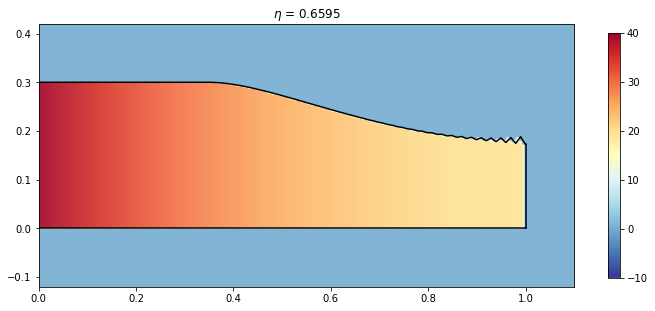

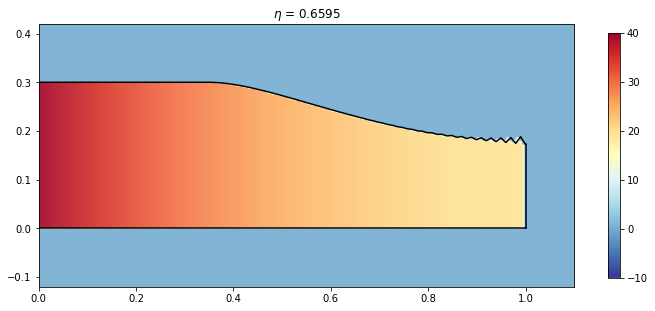

In [26]:
print( "Number of iterations: {}. Profiles tested: {}. Efficency values: {}.".format(N_max,len(profiles),len(etas)) )
print('Simulation time = ' + str(end_time-start_time) )
print('Time per step = ' + str( (end_time-start_time)/N_max ) )

# Plotting results


def generate_progression_gif(): # Need to check this function. Bad coding practice
    with imageio.get_writer('optimization_evolution.gif', mode='I') as writer:
        for i in range(0,N_max,save_freq):
            img = plot_profile_with_temp(profiles[i],bottom_profile,thetas_log[i],'',etas[i],save=False)
            plt.savefig(str(i),bbox_inches='tight',transparent=False,facecolor='white')
            plt.close(img)
            image = imageio.imread(str(i)+".png")
            writer.append_data(image)
            os.remove(str(i)+".png")


# plot_profile(current_profile,'last_iteration.png',eta,False)
plot_profile_with_temp(current_profile,bottom_profile,thetas,'h',eta,save=False)
print("Last efficiency: {:.4f}".format(eta))
# print(current_profile)

eta = np.amax(etas)
index = np.argmax(etas)
# plot_profile(profiles[index],'best_iteration.png',eta, False)
plot_profile_with_temp(current_profile,bottom_profile,thetas,'h',eta,save=False)

print("Best efficiency: {:.4f}".format(eta))
# print(profiles[index])

generate_progression_gif()